In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from scipy import stats
from matplotlib.offsetbox import AnchoredText

In [18]:
# Coordonates of key points
GEI_coordinate = (43.570819, 1.466246) 
LoRa_antenas = [(43.570819, 1.466246)]

In [53]:
# Python 3 program to calculate Distance Between Two Points on Earth
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in meters . Use 3956 for miles
    r = 6371000
      
    # calculate the result
    return(c * r)


In [20]:
def create_distance(lattitude, longitude,GEI_coordinate):
    dist = []
    n =len(lattitude)
    for i in range(n) :
        lat=lattitude[i]
        long=longitude[i]
        dist.append(distance(lat, GEI_coordinate[0], long,GEI_coordinate[1]))
    return dist

In [54]:
data = pd.read_csv(r'data.csv')
data.insert(0, 'dist', create_distance(data['lattitude'], data['longitude'], GEI_coordinate))
data.insert(0,'Lp',14-data['rssiPacket'])
data['Lp'].apply(lambda x: float(x))
sorted_data = data.sort_values(by=['dist'])

splitData=[]
for i in range (10):
    splitData.append(sorted_data.iloc[i*100 :(i+1)*100])

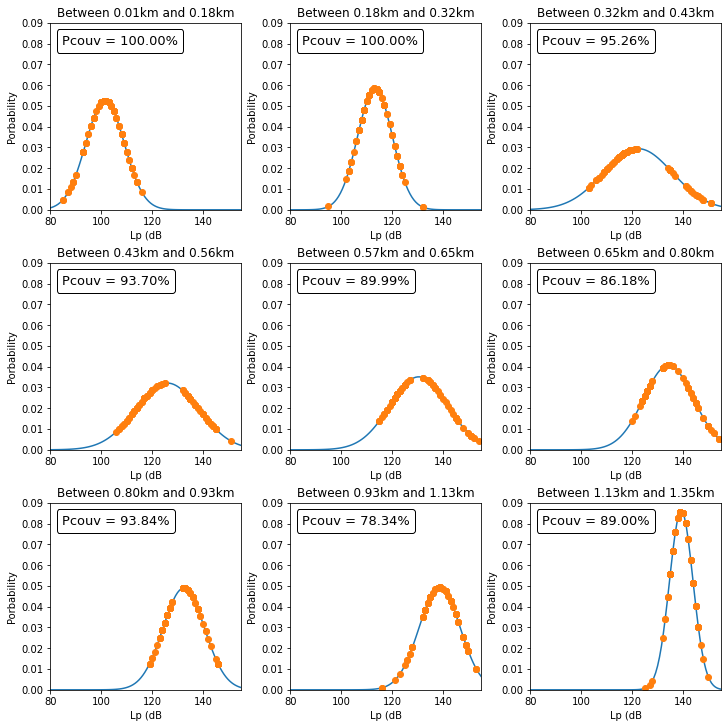

In [22]:
Means=[]
Dists=[]
Lp_max=145
x = np.linspace(80,155,100)
pdf_result = stats.norm.pdf(x,loc=3,scale=2)
fig, axs = plt.subplots(3, 3, constrained_layout=True)
fig.set_size_inches(10,10)

for i, df in enumerate(splitData) :
    mu=df['Lp'].mean()
    std=df['Lp'].std()
    max_dist=df['dist'].max()
    min_dist=df['dist'].min()

    Means.append(mu)
    Dists.append(df['dist'].mean())

    normal = lambda x,mu,std : 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * std**2))
    pdf_result = stats.norm.pdf(x,loc=mu,scale=std)
    P_couv = stats.norm.cdf(Lp_max,loc=mu,scale=std)

    axs.flat[i].plot(x,pdf_result)
    axs.flat[i].plot(df['Lp'],normal(df['Lp'],mu,std),'o')

    # Styling
    axs.flat[i].set_title(f'Betwee {min_dist/1000:.2f}km and {max_dist/1000:.2f}km')
    at = AnchoredText(f"Pcouv = {(P_couv*100):.2f}%", prop=dict(size=13), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axs.flat[i].add_artist(at)
    axs.flat[i].set_xlim([80, 155])
    axs.flat[i].set_xlabel(f"Lp (dB")
    axs.flat[i].set_ylim([0, 0.09])
    axs.flat[i].set_ylabel(f'Porbability')

In [50]:
def Hata(d,Hte,Hre,f) :
    CH = 0.8 +((1.1*np.log10( f))-0.7)*Hre - 1.56*np.log10(f) #For small or medium-sized city
    L=69.55+26.16*np.log10(f)-13.82*np.log10(Hte)-CH+(44.9-6.55*np.log10(Hte))*np.log10(d)
    return L

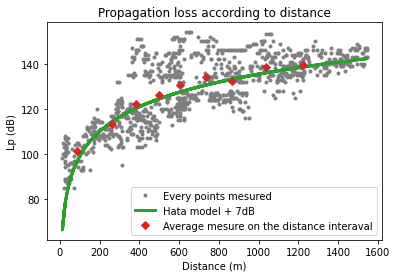

In [52]:
Hte= 20 #Base Station Height m
Hre=1.5 #Mobile Station Antenna Height m
f=868   #Frequecy Mhz

plt.plot(data['dist'], data['Lp'], '.', color='tab:gray', label='Every points mesured')
plt.plot(data['dist'], Hata(data['dist']/1000, Hte, Hre, f) + 7, label='Hata model + 7dB',
            linewidth=3,
            color='tab:green')
plt.plot(Dists,Means,'D', label='Average mesure on the distance interaval', color='tab:red')

# Styling
plt.title('Propagation loss according to distance')
plt.ylabel('Lp (dB)')
plt.xlabel('Distance (m)')
plt.legend()
plt.show() 